# **STUDENT AI** - MATH MODEL CREATION (CLASSIFICATION)

## Objectives

Create a classification model to predict Math score based on Key dataset features. Numerical variables will be grouped into bins. <br> 
Initially I will try to use 5, analog to the EDA study grouping student performance based on the mean value and 1-2 standard deviations from mean. That would allow the model to predict students in the fail, below average, average, above average and exeptional categories. - however accuracy is still a concearn, so alternative classification will be analysed using 3 bins. This will allow prediction of below average, average and above average performance and will probably achieve higher accuracy in prediction. <br>
Worst case, the dataset would have to be grouped into 2 bins around the mean allowing classification into below average and above average.

This would flag many more students however of needing additional assistance. 

## Inputs

Continues to assess dataset loaded in previous notebook.

## Outputs

None. Assess whether the optimum 5 bin classification approach is viable.


---

## Build Pipeline for classification model to predict Math numerical target variable

The steps for a classification model are a little more involved when using a dataset with a numerical target variable

| Step |  Purpose | 
|---|---|
|Data Cleaning|Deal with missing data or wrong data - step already completed in the saved dataset|
|Discretize Numerical Target|group target variable into bins for categorization|
|Encode Categorical Features|Model algorithms can only handle numerical data. Needs to be converted first|
|Data Balancing|Classification models are affected negatively by imbalanced data. SMOTE or Undersampling needs to be performed to balance the dataset|
|Feature Smart Correlation|Determine which features are most significant and eliminate uneccessary ones - helps prevent overfitting - **not neccesary**|
|Feature Selection|Select which features will be used |
|Algorithm Selection|Assess best algorithm for the data set as well as the best associated Parameters and Hyperparameters|
|Model Training|Train the model on the train data and evaluate with the test set|


# Import required libraries

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

### Pipeline
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### libraries for custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

### Feature Balancing
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### Feature  Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

### EqualFrequencyDiscretiser
from feature_engine.discretisation import EqualFrequencyDiscretiser

### packages for classification report and confusion matrix
from sklearn.metrics import make_scorer, recall_score

### Train test split
from sklearn.model_selection import train_test_split

### Packages for generating a classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

### GridSearchCV
from sklearn.model_selection import GridSearchCV

print('All Libraries Loaded')

All Libraries Loaded


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Change working directory

### Set the working directory to notebook parent folder
If the output does not match, click **'clear all outputs'** and then **'restart'** the notebook. 
Then run cells from top to bottom.

In [2]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print('If correct, Active Directory should read: /workspace/student-AI')
print(f"Active Directory: {current_dir}")

If correct, Active Directory should read: /workspace/student-AI
Active Directory: /workspace/student-AI


### Load cleaned dataset

In [8]:
df = pd.read_csv(f"outputs/dataset/Expanded_data_with_more_features_clean.csv")
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,C,bachelor,standard,not completed,married,regularly,yes,3,schoolbus,Less than 5 hours,71,71,74
1,female,C,college,standard,not completed,married,sometimes,yes,0,schoolbus,Between 5-10 hours,69,90,88
2,female,B,masters,standard,not completed,single,sometimes,yes,4,schoolbus,Less than 5 hours,87,93,91
3,male,A,associates,free,not completed,married,never,no,1,schoolbus,Between 5-10 hours,45,56,42
4,male,C,college,standard,not completed,married,sometimes,yes,0,schoolbus,Between 5-10 hours,76,78,75


nrSiblings is treated as a numerical variable. As I determined previously it has no bearing on the target variables, so I will drop it rather than convert to categorical. The other variables previously identified in the EDA as having not much impact, I will keep in, as the Feature Selection step did not suggest to eliminate any. I will also drop teh features that the EDA determined has no bearing on the target variables.

In [9]:
df_math = df.drop(['ReadingScore', 'WritingScore','NrSiblings','ParentMaritalStatus', 'PracticeSport','IsFirstChild','NrSiblings','WklyStudyHours','TransportMeans'], axis=1)
df_math.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore
0,female,C,bachelor,standard,not completed,71
1,female,C,college,standard,not completed,69
2,female,B,masters,standard,not completed,87
3,male,A,associates,free,not completed,45
4,male,C,college,standard,not completed,76


In [11]:
def PipelineOptimization(model):
    pipeline_base = ImbPipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary', 
            variables=[
                'Gender',
                'EthnicGroup',
                'ParentEduc',
                'LunchType',
                'TestPrep',
                ])),

        #("undersample", RandomUnderSampler()),  # Assuming enough data values - another option will be SMOTE
        # ("oversample", SMOTE()),  # alternate balancing technique -- only allow one or teh other until best option is determined

        ("feature_selection", SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

In [12]:
models_algorithm_list = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

parameters_list = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

### Custom Confusion Matrix Function from CI Customer Churn Course

In [13]:
def confusion_matrix_and_report(x, y, pipeline, label_map):

  prediction = pipeline.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")

  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")

def clf_performance(math_train_features, math_train_scores, math_test_features, math_test_scores, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(math_train_features, math_train_scores, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(math_test_features, math_test_scores, pipeline, label_map)

### Custom Hyperparameter search class (same as previous notebook)

To select the best algorithm and hyperparameters we will fit a model with each different type / parameter set and compare the results.
To do this I can use the custom parameter test function, derived in the CodeInstitute Churnometer Walkthrough [here](https://github.com/AdamBoley/churnometer/blob/main/jupyter_notebooks/06%20-%20Modeling%20and%20Evaluation%20-%20Predict%20Tenure.ipynb)

In [14]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, parameters):
        self.models = models
        self.parameters = parameters
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, x, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model =  PipelineOptimization(self.models[key])

            parameters = self.parameters[key]
            grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            grid_search.fit(x, y)
            self.grid_searches[key] = grid_search

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, parameters):
            summary = {
                 'estimator': key,
                 'minimum_score': min(scores),
                 'maximum_score': max(scores),
                 'mean_score': np.mean(scores),
                 'standard_deviation_score': np.std(scores),
            }
            return pd.Series({**parameters,**summary})

        rows = []
        for k in self.grid_searches:
            parameters = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                result = self.grid_searches[k].cv_results_[key]        
                scores.append(result.reshape(len(parameters), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(parameters, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'minimum_score', 'mean_score', 'maximum_score', 'standard_deviation_score']
        columns = columns + [column for column in df.columns if column not in columns]

        return df[columns], self.grid_searches

### Create 5 bins in Math Target variable column

* The classes represent the following ranges: 
{'MathScore': [-inf, 53.0, 63.0, 71.0, 80.0, inf]} 



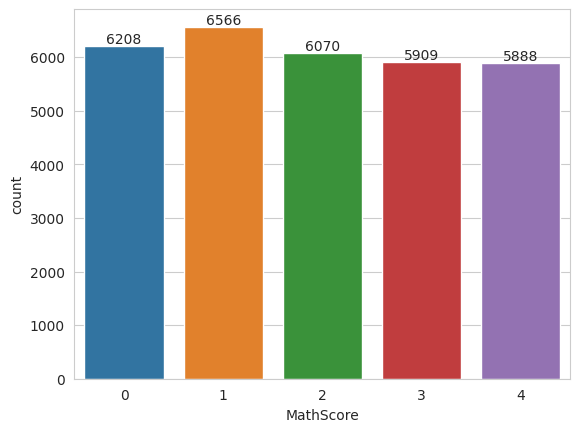

In [16]:
df_transformed = EqualFrequencyDiscretiser(q=5, variables=['MathScore'])
df_maths_bins = df_transformed.fit_transform(df_math)

print(f"* The classes represent the following ranges: \n{df_transformed.binner_dict_} \n")
fig_maths_bins = sns.countplot(data=df_maths_bins, x='MathScore')
plt.bar_label(fig_maths_bins.containers[0])
plt.show()

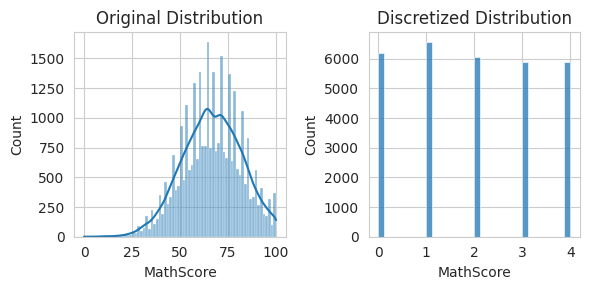

In [18]:
plt.figure(figsize=(6, 3))

# Original distribution
plt.subplot(1, 2, 1)
sns.histplot(df['MathScore'], bins='auto', kde=True)
plt.title('Original Distribution')

# Discretized distribution
plt.subplot(1, 2, 2)
sns.histplot(df_maths_bins['MathScore'], bins='auto', kde=False)
plt.title('Discretized Distribution')

plt.tight_layout()
plt.show()

### Check dataframe after discretization

In [19]:
df_maths_bins

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore
0,female,C,bachelor,standard,not completed,2
1,female,C,college,standard,not completed,2
2,female,B,masters,standard,not completed,4
3,male,A,associates,free,not completed,0
4,male,C,college,standard,not completed,3
...,...,...,...,...,...,...
30636,female,D,highschool,standard,not completed,1
30637,male,E,highschool,standard,not completed,1
30638,female,C,highschool,free,completed,1
30639,female,D,associates,standard,completed,4


### Start model tests

In [20]:
math_train_features, math_test_features, math_train_scores, math_test_scores = train_test_split(
    df_maths_bins.drop(['MathScore'], axis=1),
    df_maths_bins['MathScore'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", math_train_features.shape, math_train_scores.shape, "\n* Test set:",  math_test_features.shape, math_test_scores.shape)

* Train set: (24512, 5) (24512,) 
* Test set: (6129, 5) (6129,)


### Check distribution of training set

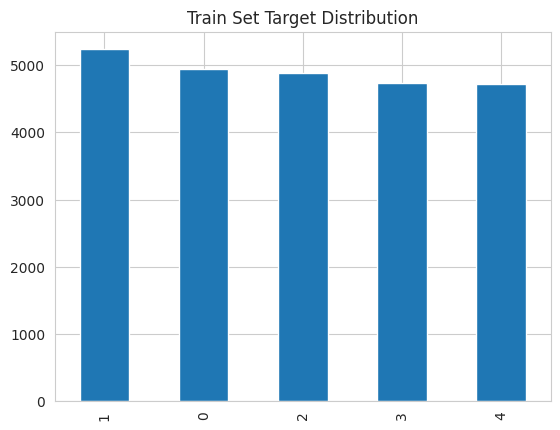

In [21]:
sns.set_style("whitegrid")
math_train_scores.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

### Balance Data
This plot shows the data is imbalanced, especially teh fail grades (0). Since I am primarily interested in lower performing students and there are many datarows and the majority is in the average category (3) I will use undersample to randomly remove values from the majority values. This will likely greatly reduce teh total rows, but should still be enough to train the model on and then test on the reserved test data.

In [22]:
undersample = RandomUnderSampler(random_state=0)
math_train_features, math_train_scores = undersample.fit_resample(math_train_features, math_train_scores)
print(math_train_features.shape, math_train_scores.shape)

(23625, 5) (23625,)


### Check balanced plot...

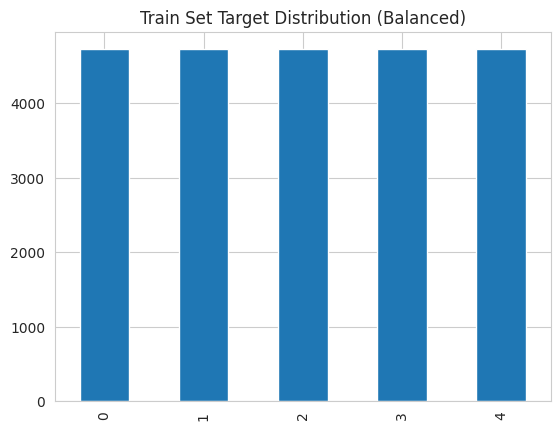

In [23]:
math_train_scores.value_counts().plot(kind='bar', title='Train Set Target Distribution (Balanced)')
plt.show()

### Analysis
This plot shows the resulting Target distribution is now well balanced and as predicted greatly reduced in numbers (2865 rows vs 30000+)

In [24]:
model_search = HyperparameterOptimizationSearch(models=models_algorithm_list, parameters=parameters_list)
model_search.fit(math_train_features, math_train_scores, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)



Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be remo


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [25]:
model_grid_search_summary, model_grid_search_pipelines = model_search.score_summary(sort_by='mean_score')
model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
5,AdaBoostClassifier,0.555556,0.635979,0.684656,0.046546
0,XGBClassifier,0.617989,0.624127,0.645503,0.010696
1,DecisionTreeClassifier,0.585185,0.592381,0.612698,0.010225
2,RandomForestClassifier,0.585185,0.592381,0.612698,0.010225
3,GradientBoostingClassifier,0.585185,0.592381,0.612698,0.010225
4,ExtraTreesClassifier,0.585185,0.592381,0.612698,0.010225


### Analysis
The algorithm search shows the best Classifier is the AdaBoostClassifier with a mean score of 0.64. This is above the desired value of 0.6 so I will proceed with it. XGB Classifier is slightly lower at 0.62, so it might improve to a better position with some optimized hyperparameters. The next step will therfore use the 2 best Classifiers and generate results for different hyperparameter combinations to see if the value can be improved.

### Define Hyperparameter list for 2 best models and apply to evaluate the best options

In [26]:
best_models = {
    "XGBClassifier": XGBClassifier(random_state=0),
    # "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}
 
test_parameters = {
    "XGBClassifier":{'model__n_estimators': [30,80,200],
                      'model__max_depth': [None, 3, 15],
                      'model__learning_rate': [0.01,0.1,0.001],
                      'model__gamma': [0, 0.1],
                            },

    # "GradientBoostingClassifier":{'model__n_estimators': [100,50,140],
    #                               'model__learning_rate':[0.1, 0.01, 0.001],
    #                               'model__max_depth': [3,15, None],
    #                               'model__min_samples_split': [2,50],
    #                               'model__min_samples_leaf': [1,50],
    #                               'model__max_leaf_nodes': [None,50],
    #                         },

    "AdaBoostClassifier":{'model__n_estimators': [50,25,80,150],
                          'model__learning_rate':[1,0.1, 2],
                            }
  }

In [27]:
parameters_search = HyperparameterOptimizationSearch(models=best_models, parameters=test_parameters)
parameters_search.fit(math_train_features, math_train_scores, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be re


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [28]:
parameters_grid_search_summary, parameters_grid_search_pipelines = parameters_search.score_summary(sort_by='mean_score')
parameters_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__gamma,model__learning_rate,model__max_depth,model__n_estimators
63,AdaBoostClassifier,0.862434,0.882116,0.888889,0.01003,NaN,2,NaN,25
57,AdaBoostClassifier,0.555556,0.635979,0.684656,0.046546,NaN,1,NaN,150
56,AdaBoostClassifier,0.555556,0.635979,0.684656,0.046546,NaN,1,NaN,80
54,AdaBoostClassifier,0.555556,0.635979,0.684656,0.046546,NaN,1,NaN,50
0,XGBClassifier,0.617989,0.624127,0.645503,0.010696,0,0.01,None,30
...,...,...,...,...,...,...,...,...,...
60,AdaBoostClassifier,0.443386,0.482116,0.584127,0.052963,NaN,0.1,NaN,80
58,AdaBoostClassifier,0.443386,0.465397,0.500529,0.022631,NaN,0.1,NaN,50
62,AdaBoostClassifier,0.092063,0.384762,0.461376,0.14637,NaN,2,NaN,50
64,AdaBoostClassifier,0.092063,0.384762,0.461376,0.14637,NaN,2,NaN,80


### Analysis
The AdaBoostClassifier achieve a significanclty better result with 0.88 mean score. I will use those hyperparameters for the model training.

In [29]:
maths_best_model = parameters_grid_search_summary.iloc[0,0]
maths_best_model

'AdaBoostClassifier'

In [30]:
maths_best_parameters = parameters_grid_search_pipelines[maths_best_model].best_params_
maths_best_parameters

{'model__learning_rate': 2, 'model__n_estimators': 25}

In [31]:
pipeline_classifier = parameters_grid_search_pipelines[maths_best_model].best_estimator_
pipeline_classifier

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'EthnicGroup',
                                           'ParentEduc', 'LunchType',
                                           'TestPrep'])),
                ('feature_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(learning_rate=2, n_estimators=25,
                                    random_state=0))])

* These are the 2 most important features in descending order. The model was trained on them: 
['EthnicGroup', 'ParentEduc']


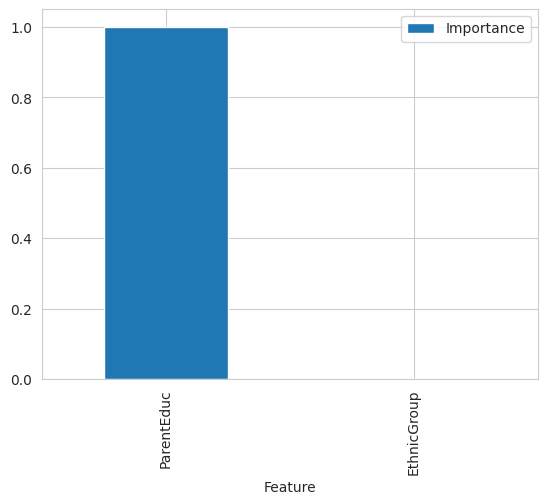

In [32]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_classifier.steps[:data_cleaning_feat_eng_steps])
                                        .transform(math_train_features)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_classifier['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[pipeline_classifier['feature_selection'].get_support()],
          'Importance': pipeline_classifier['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

maths_best_features = df_feature_importance['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

### Analysis
The hyperparameter optimiztion and pipeline test has narrowed down the feature importance to a single one (ParentEduc). Using it as the sole feature will not be a good way forward. Below I will assess the predictive power against the test set of data split earlier on.

In [33]:
label_map = ['Fail', 'Below Average','Average','Above Average','Exceptional']

In [34]:
clf_performance(math_train_features, math_train_scores, math_test_features, math_test_scores, pipeline_classifier, label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                         Actual Fail Actual Below Average Actual Average  \
Prediction Fail                 4193                 4050           3895   
Prediction Below Average           0                    0              0   
Prediction Average                 0                    0              0   
Prediction Above Average           0                    0              0   
Prediction Exceptional           532                  675            830   

                         Actual Above Average Actual Exceptional  
Prediction Fail                          3744               3530  
Prediction Below Average                    0                  0  
Prediction Average                          0                  0  
Prediction Above Average                    0                  0  
Prediction Exceptional                    981               1195  


---  Classification Report  ---
               precision    recall  f1-score   support

  

/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

## Conclusion
Unfortunately the test shows that the model is not able to predict any classes between the extremes and is so low, the function throws an error and outputs 0. The recall of 0.89 and 0.9 for fail and exceptional are high, but the majority of the students will fall within the mean +- 1 SD so this will not be of any use. 

I will repeat the pipeline optimization using 3 instead of 5 bins to see if that improves the predictive power.